# I. Introduction

This project objective is to create ANN model for image prediction (computer vision) from dataset image that classify workplace safety condition (safety and unsafety). Model created with TensorFlow library, first model is baseline and then created the improvement to use as final model. Metric evalution used is classification report with focus on Recall, Controlling recall is to minimize Flase Negatives (FN), which is critical in safety-related tasks. Final model tested with new image data (inference) and also conducted deployment model with streamlit to huggingface ploatform.

# II. Import Libraries

In [1]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications import MobileNetV2

import warnings
warnings.filterwarnings('ignore')

# III. Data Loading

In [2]:
# Define path

main_path = 'Worksite-Safety-Monitoring-Dataset/'
train_path = os.path.join(main_path, 'train')
val_path = os.path.join(main_path, 'valid')
test_path = os.path.join(main_path, 'test')

Above is to define location folder and data in dataset. Dataset has three set of data, those are train, valid and test.

In [ ]:
# Check how many data in train_path, val_path and test_path

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Val Path')
check_path(val_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - safe : 810
Total Data - unsafe : 810

Val Path
Total Data - safe : 100
Total Data - unsafe : 100

Test Path
Total Data - safe : 100
Total Data - unsafe : 100



Based on result above, in dataset have two class of data, that is safe and unsafe class. Total data also same between two class in every set of data, that makes the data balance.

# IV. Exploratory Data Analysis (EDA)

In [4]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

function is to show data in every data set.

Class :  safe


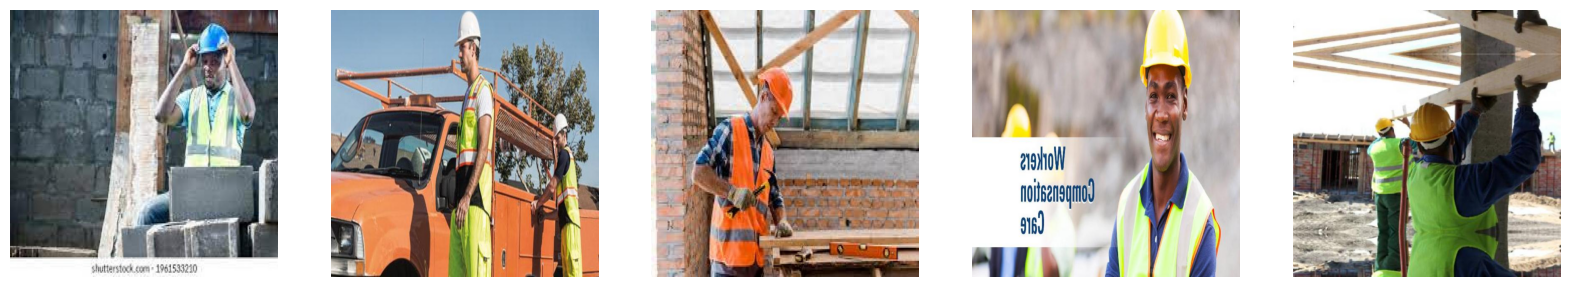

Class :  unsafe


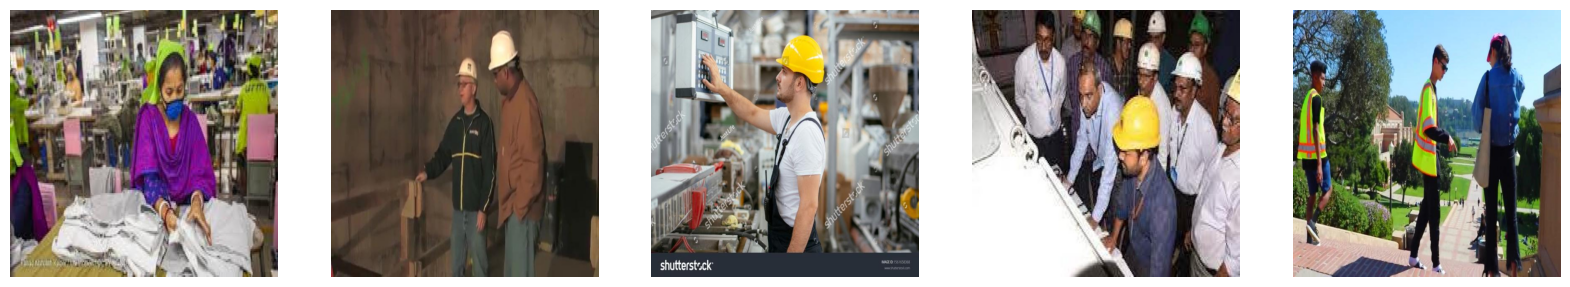

In [5]:
# Train data

plot_images(train_path)

Class :  safe


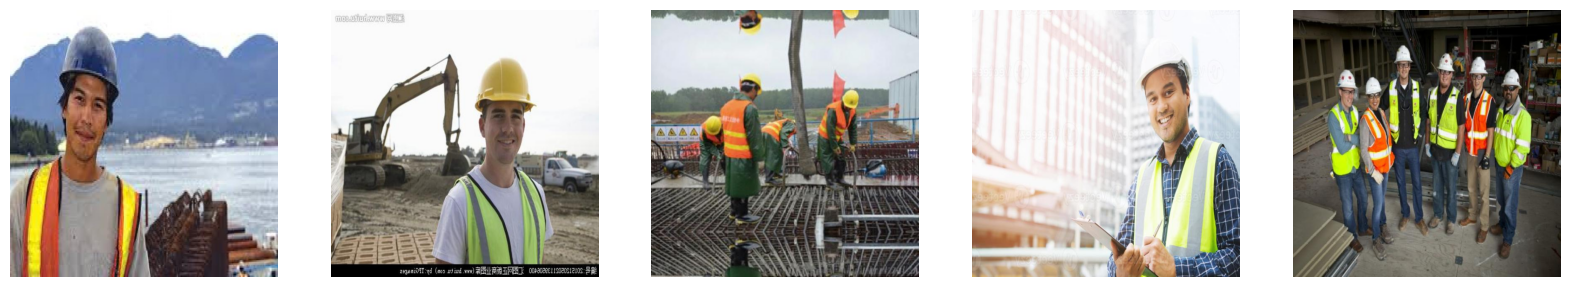

Class :  unsafe


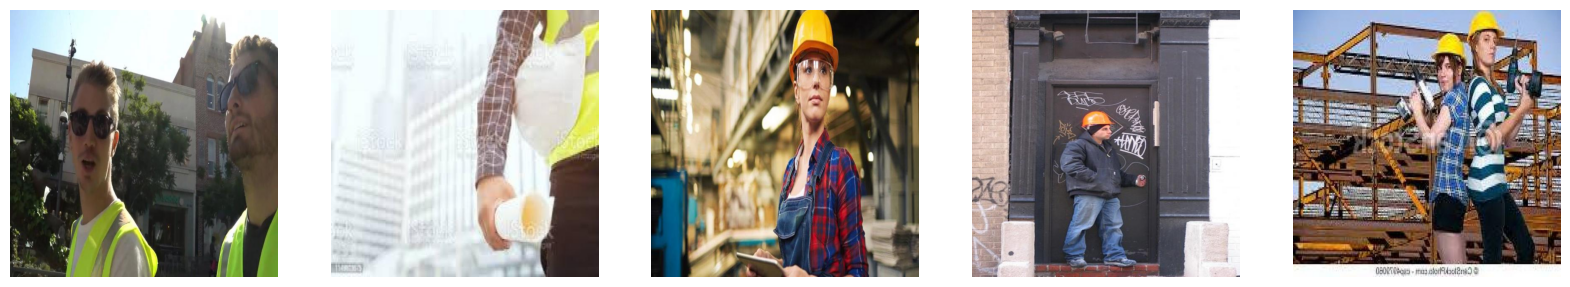

In [6]:
# Val data

plot_images(val_path)

Class :  safe


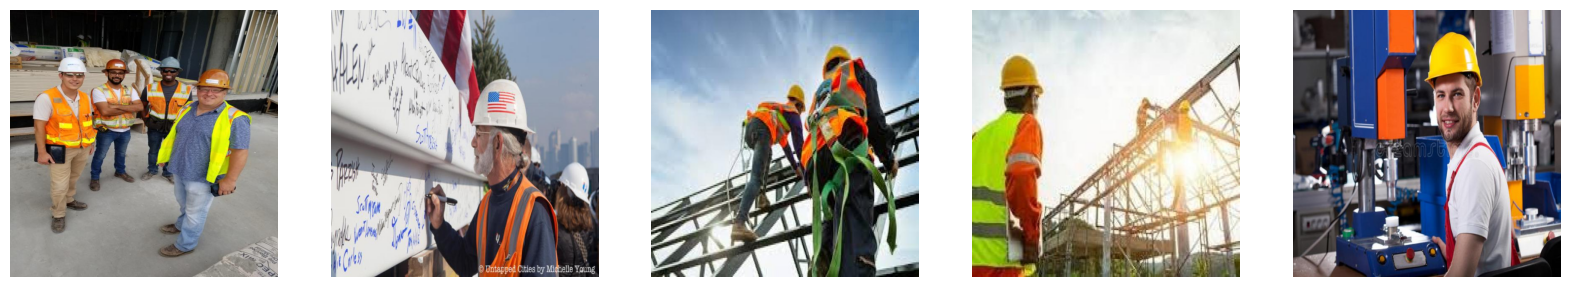

Class :  unsafe


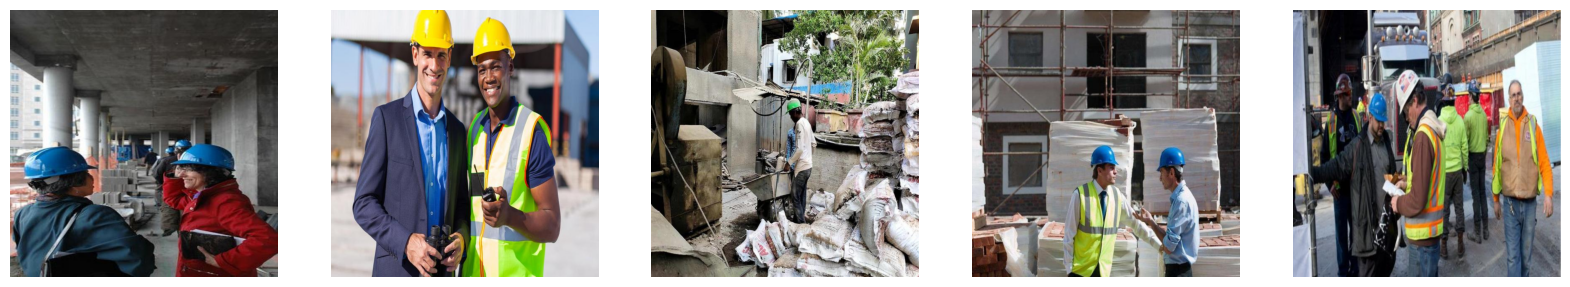

In [7]:
# Test data

plot_images(test_path)

- From the visualization results, it can be seen that the images mostly depict people performing tasks in industrial environments across various sectors such as manufacturing, construction, and others. What stands out in the images are the safety helmets and vests, which have much brighter colors compared to other objects. Notably, in the unsafe class, there are also images of people wearing safety helmets but not wearing safety vests, this is good for model learning as it prevents bias, such as assuming that wearing a helmet only implies safety. There are also some images that do not show full of people but only body parts or PPE only.
- From the dataset, it's apparent that the image sizes are consistent, and all images have the same pixel dimensions, allowing the model to properly see each one. The image sizes will also be resized uniformly during model preprocessing.
- These images are of people in work environments. The color channels are kept in RGB format because PPE (Personal Protective Equipment) typically comes in bright, vivid colors.
- The images are mostly landscape or portrait photos of people working in various workplace settings, taken from different angles and distances (both close-up and wide shots). This variation may help the model learn more comprehensively, but the challenge is whether the dataset is large and varied enough for effective learning.
- Another challenge is that the images involve different activities, locations, and body positions, with individuals wearing various types of PPE. Therefore, evaluating model performance carefully is crucial to ensure prediction accuracy.

# V. Feature Engineering

In [8]:
# Define hyperparameters

img_height= 200
img_width= 200
batch_size= 64

Define hyperparameters, dimension using 200x200, so model can learn quickly, but not small enough to make images blur.

In [9]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                rotation_range=20,
                                                                zoom_range=0.05,
                                                                width_shift_range=0.05,
                                                                height_shift_range=0.05,
                                                                shear_range=0.05,
                                                                horizontal_flip=True)

train_set = train_datagen.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='binary',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=2)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                              rotation_range=20,
                                                              zoom_range=0.05,
                                                              width_shift_range=0.05,
                                                              height_shift_range=0.05,
                                                              shear_range=0.05,
                                                              horizontal_flip=True)

val_set = val_datagen.flow_from_directory(val_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 1620 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


- In preprocessing doing data/imgae augmentation that help model to learn more image variants then increase generalization model and avoid overfitting. The agumentations are rotation_range, zoom_range, width_shift_range, height_shift_range, shear_range and horizontal_flip with suitable setting. some augmentation did't apply, because it is not suitable in this case such as vertical_flip.
- class_mode using binary because this case only have two class of data.

In [10]:
# Show labels

train_set.class_indices

{'safe': 0, 'unsafe': 1}

Checking the label of the call, for unsafe is 1 or positif. In industry checking unsafe is more critical beacause it needs further action to avoid accident now or in the future.

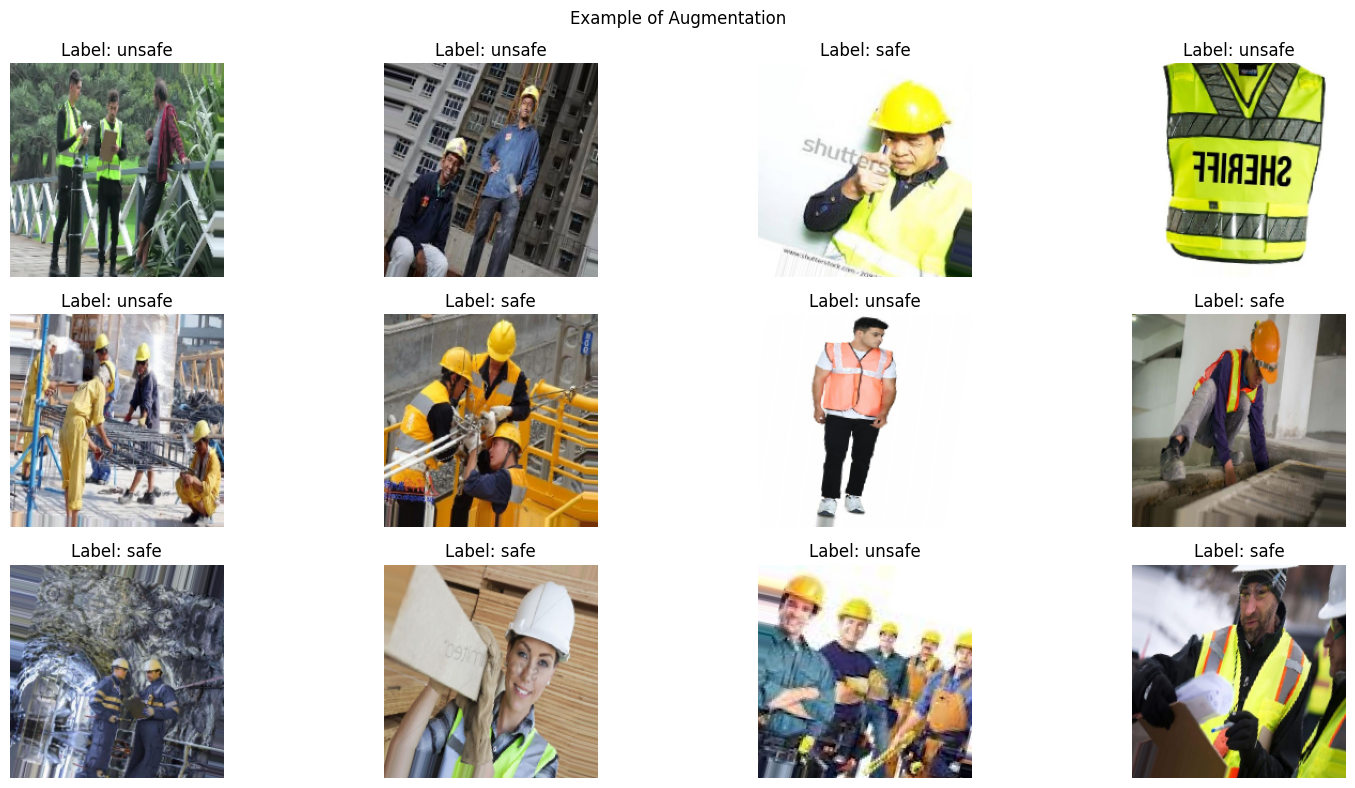

In [11]:
# Check augmentation from train_set

images, labels = next(train_set)

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {'safe' if labels[i]==0 else 'unsafe'}")
    plt.axis('off')
plt.suptitle("Example of Augmentation")
plt.tight_layout()
plt.show()

Checking the result of data augmentation, from the example results above there is no image that changed too extreme, all are still visible and makesanse.

# VI. ANN Training (Sequential API)

## vi.1. Model Definition

In [12]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
# Model

# Create Sequential API model
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

- For baseline model, using Sequentional API so the architecture layer is linear, easier to monitor.
- Next layer are three convolution and pooling layer for CNN model requirement, to reduce weights of the images for train the datas.
- Next layer is flatten and then hidden layer with 256 neurons with relu activation.
- last layer is output layer with sigmoid activation, because this case is binary classification.

## vi.2. Model Training

In [14]:
# Train the model

history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
26/26 [==============================] - 20s 736ms/step - loss: 1.0700 - accuracy: 0.5105 - val_loss: 0.6922 - val_accuracy: 0.5200
Epoch 2/20
26/26 [==============================] - 19s 723ms/step - loss: 0.6923 - accuracy: 0.5173 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/20
26/26 [==============================] - 19s 722ms/step - loss: 0.6852 - accuracy: 0.5296 - val_loss: 0.6832 - val_accuracy: 0.4850
Epoch 4/20
26/26 [==============================] - 19s 725ms/step - loss: 0.6810 - accuracy: 0.5500 - val_loss: 0.6751 - val_accuracy: 0.5800
Epoch 5/20
26/26 [==============================] - 20s 742ms/step - loss: 0.6534 - accuracy: 0.6160 - val_loss: 0.6540 - val_accuracy: 0.6000
Epoch 6/20
26/26 [==============================] - 19s 724ms/step - loss: 0.6450 - accuracy: 0.6302 - val_loss: 0.6276 - val_accuracy: 0.6700
Epoch 7/20
26/26 [==============================] - 19s 723ms/step - loss: 0.6415 - accuracy: 0.6259 - val_loss: 0.6397 - val_accuracy: 0.6300

Model train untill 20 epoch.

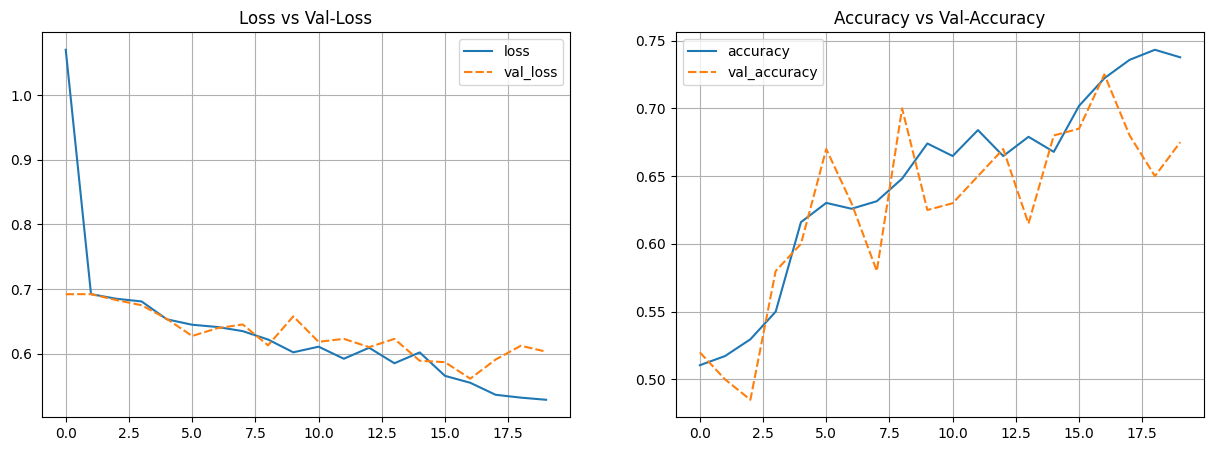

In [15]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Based on training result, The model shows steady improvement over time in both training and validation performance. Both training and validation losses decreased over time, indicating that the model was effectively learning the underlying patterns in the data. Although the validation accuracy remained slightly behind the training accuracy, maybe a little overfitting, the overall training behavior was healthy and stable, but the accuracy not that high, for this is still not suitable to apply in this case of safety in industry. This model still can be a baseline for improvment.

## vi.3. Model Evaluation

In [16]:
# Check the performance of test-set

# Get the probability
y_pred_prob = model.predict(test_set)

# Get class with maximum probability
y_pred_class = np.where(y_pred_prob >= 0.5, 1, 0)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

4/4 [==============================] - 1s 141ms/step
              precision    recall  f1-score   support

        safe       0.63      0.77      0.69       100
      unsafe       0.71      0.55      0.62       100

    accuracy                           0.66       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.67      0.66      0.66       200



- In this project classifying safe vs unsafe working conditions, recall is the most critical evaluation metric because the consequences of missing an unsafe condition are far more serious than falsely labeling a safe condition as unsafe. Decreasing that False Negative (FN) is the main focus in tithis project. If the model fails to detect an unsafe image, it may result in overlooking a dangerous working condition. In real world safety applications, this could mean that a worker without proper PPE can calssify as safe/negative, potentially leading to accidents, injuries, or even fatalities. Minimizing these false negatives is therefore essential for protecting workers and maintaining safety compliance.
- The evaluation results show that the model achieved an overall accuracy of 66%, indicates moderate performance only, deeper insight comes from the recall values. For the safe class, the recall is 0.77, indicating the model correctly identified 77% of actual safe conditions. However, the recall for the "unsafe" class is 0.55, meaning it only caught 55% of unsafe situations, not meet the expectations, especially when safety detection is the main objective. Although the model is reasonably accurate overall, the lower recall for the unsafe class highlights a critical area for improvement. To align better with the project goal, which prioritizes both accuracy and high recall, especially for unsafe cases, further improvement may be necessary to reduce the risk of missing dangerous working conditions.

# VII. ANN Improvement (Sequential API)

## vii.1. Model Definition

In [17]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Improvement model applied baseline model sequential API architecture and include transfer learning, normalization layer and callback.

In [ ]:
# Model Improvement

# Create Sequential API model
tl_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

tl_model.trainable = False

model_imp = Sequential()
model_imp.add(tl_model)
model_imp.add(Flatten())
model_imp.add(Dense(256, activation='relu'))
model_imp.add(BatchNormalization())
model_imp.add(Dense(1, activation='sigmoid'))

# Compile
model_imp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2)

model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18315841 (69.87 MB)
Trainable params: 1605

Improvement:

- Transfer Learning: In your project, Transfer Learning is used to classify images of safe and unsafe working conditions by leveraging a pre-trained model MobileNetV2 that has already learned rich visual features from the ImageNet dataset. Transfer learning needed because the dataset is relatively limited and also from EDA the images data have a lot variant with small dataset, transfer learning give strong performance with little data. Also traning time is faster and more stable. MobileNetV2 is choosen because it is built on depthwise separable convolutions and inverted residual blocks, significantly reducing parameters and computational cost, that is why convolution layer from baseline is not included again here. This model also has good accuracy, fast training, light and has small size, suitable as well for deployment.

- Batch Normalization: the layer after hidden layer with 256 neurons, it normalizes the output of a layer by adjusting and scaling the activations. It helps to reduce internal covariate shift and stabilizes the learning process. It also accelerates training, improves model stability, and helps prevent overfitting.

- Early Stopping: a callback that monitors a specific metric (this case use validation accuracy). If the metric doesn't improve after a few epochs (this case 4), training stops automatically and restores the best model weights. This is to save training time as well.

- Reduce LR: this callback monitors a chosen metric and reduces the learning rate if it stops improving after a few epochs (factor in this case 0.2 and patience 2). A smaller learning rate allows the model to make finer updates to weights. It helps model converge better when progress slows down, which can lead to higher accuracy.

## vii.2. Model Training

In [19]:
# Train the model

history_imp = model_imp.fit(train_set, epochs=20, validation_data=val_set, callbacks=[early_stop, reduce_lr], batch_size=batch_size)

Epoch 1/20
26/26 [==============================] - 12s 414ms/step - loss: 0.8648 - accuracy: 0.7222 - val_loss: 1.2656 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 2/20
26/26 [==============================] - 10s 385ms/step - loss: 0.3813 - accuracy: 0.8358 - val_loss: 0.8830 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
26/26 [==============================] - 10s 382ms/step - loss: 0.3042 - accuracy: 0.8716 - val_loss: 0.6748 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 4/20
26/26 [==============================] - 10s 380ms/step - loss: 0.2804 - accuracy: 0.8827 - val_loss: 0.6192 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/20
26/26 [==============================] - 10s 382ms/step - loss: 0.2531 - accuracy: 0.9025 - val_loss: 0.4854 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 6/20
26/26 [==============================] - 10s 381ms/step - loss: 0.2110 - accuracy: 0.9222 - val_loss: 0.5316 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 7/20
26/26 [==============================] - 10s 382ms/st

Training model each epoch is faster than baseline model. Model train plan until 20 epoch same as baseline, but already finished at 13 epoch, because of early stop, this is also save time from unecessery further training. Learning rate also reduce in certain point, it helps model converge.

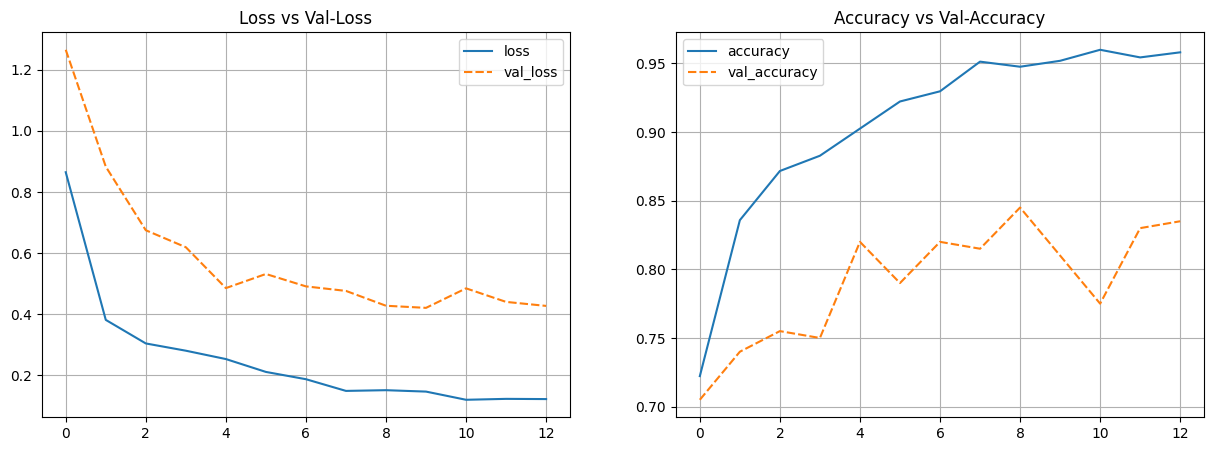

In [20]:
# Plot training results

history_imp_df = pd.DataFrame(history_imp.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_imp_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_imp_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

The training results demonstrate a strong and stable learning process of the model. Initially, the model starts with a relatively high loss, but it quickly achieves a good level of accuracy, likely due to the use of transfer. Over the first few epochs, both training and validation accuracy improve significantly, indicating that the model is successfully learning the patterns in the data. By epoch 5, the training accuracy reaches over 90% and the validation accuracy climbs to 82%, showing good generalization.. Although the training accuracy continues to increase and exceeds 95%, the validation accuracy stabilizes around 84%, suggesting the model is close to its optimal performance on the current dataset. Overall, the training progress confirms that the model is effective and benefits from improvements, resulting in high accuracy without signs of severe overfitting.

## vii.3. Model Evaluation

In [21]:
# Check the performance of test-set

# Get the probability
y_pred_prob_imp = model_imp.predict(test_set)

# Get class with maximum probability
y_pred_class_imp = np.where(y_pred_prob_imp >= 0.5, 1, 0)

# Display Classification Report
print(classification_report(test_set.classes, y_pred_class_imp, target_names=np.array(list(train_set.class_indices.keys()))))

4/4 [==============================] - 1s 213ms/step
              precision    recall  f1-score   support

        safe       0.84      0.87      0.85       100
      unsafe       0.86      0.83      0.85       100

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200



The improvement model achieved an overall accuracy of 85% on the test set, which is good and better than baseline model. Also for the safe class, it obtained recall of 0.87 which is also incraese. On the other hand, the more important for the unsafe class, the model scored recall of 0.83, indicating it’s also strong in detecting unsafe conditions. The result making the model suitable to use or for deployment where both correct identification of hazards are important.

# VIII. Model Saving

In [22]:
# Model summary

model_imp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18315841 (69.87 MB)
Trainable params: 1605

The model summary before saving. have the information of layer, shape, param and also size.

In [24]:
# Save ANN model

model_imp.save('model.keras')

Model has been saved.

# IX. Model Inference

Model Inference was conducted in file notebook_inf.ipynb

# X. Conclusion

- The Dataset consists mainly of images depicting individuals working in diverse industrial settings, such as manufacturing and construction, where brightly colored safety helmets and vests are prominent features that aid the model in distinguishing safe and unsafe conditions. The dataset images are consistently sized and maintain color channels, which is important for accurate recognition. The photos vary in orientation, angles, and distances, providing valuable diversity for training, though the dataset's size and variety remain potential limitations. Additionally, the range of activities, environments, and PPE types adds complexity, making thorough model evaluation essential to ensure reliable and accurate predictions.

- Recall is the key metric because missing unsafe conditions (false negatives) can lead to serious risks like accidents or injuries. Minimizing false negatives ensures the model reliably detects unsafe situations, helping protect workers and maintain safety. Baseline Model has low Accuracy and Recall, with improvement that apply transfer learning (using MobileNetV2), normalization layer and callback increase the performance of the model in significant in term of faster training and time efficiency. The final result of the model is Accuracy 85% and Recall 83%. Which is suitable for prediction used and deployment. As recommendation further exploring in improvement parameter is recommended to make the possibility increase the metrics evaluation score. Long further study with others transfer learning is also recommended.

- Based on model, data inference also successfully predict with the model with possible result, when the result is safe is good as a good practice, when the result unsafe from the result in indutry suggestion to do further action like to report to the higher manager or HSE team, so the safety issue can be solved. The model also successfully deploy with streamlit at huggingface platform.